# Cargamos los datos, separamos en train, validation y test. Y Añadimos el ruido con ayuda de una ia de generacion

**Prompt: "Generate code to add Gaussian noise of snr 3db to the fashion mnist database, and also add salt and pepper noise 
In the end my data would consist on the clean fashion mnist db, the gaussian contamined fashion mnist db, and the salt and pepper contamined fashion mnist db"**

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


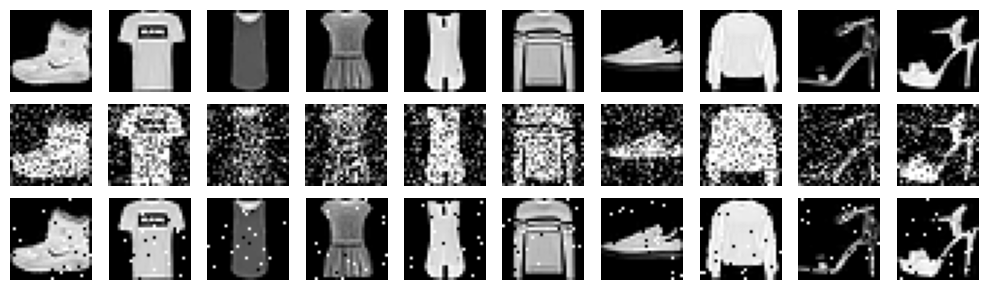

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize images to [0,1] range
x_train_full = x_train.astype(np.float32) / 255.0
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
x_test = x_test.astype(np.float32) / 255.0
y_train, y_valid = y_train[:-5000], y_train[-5000:]

# Function to add Gaussian noise with a given SNR in dB
def add_gaussian_noise(images, snr_db):
    signal_power = np.mean(images ** 2)
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)
    
    noise = np.random.normal(0, noise_std, images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0, 1)  # Ensure values remain in [0,1]

# Function to add Salt & Pepper noise
def add_salt_and_pepper_noise(images, salt_prob=0.02, pepper_prob=0.02):
    noisy_images = np.copy(images)
    total_pixels = images.shape[1] * images.shape[2]

    # Salt noise (white pixels)
    for img in noisy_images:
        num_salt = int(salt_prob * total_pixels)
        coords = [np.random.randint(0, i, num_salt) for i in img.shape]
        img[coords[0], coords[1]] = 1.0

    # Pepper noise (black pixels)
    for img in noisy_images:
        num_pepper = int(pepper_prob * total_pixels)
        coords = [np.random.randint(0, i, num_pepper) for i in img.shape]
        img[coords[0], coords[1]] = 0.0

    return noisy_images

# Generate noisy datasets
x_train_gaussian = add_gaussian_noise(x_train, snr_db=3)
x_valid_gaussian = add_gaussian_noise(x_valid, snr_db=3)
x_test_gaussian = add_gaussian_noise(x_test, snr_db=3)

x_train_saltpepper = add_salt_and_pepper_noise(x_train)
x_valid_saltpepper = add_salt_and_pepper_noise(x_valid)
x_test_saltpepper = add_salt_and_pepper_noise(x_test)


# Display sample images
fig, axs = plt.subplots(3, 10, figsize=(10, 3))

for i in range(10):
    axs[0, i].imshow(x_train[i], cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(x_train_gaussian[i], cmap="gray")
    axs[1, i].axis("off")
    axs[2, i].imshow(x_train_saltpepper[i], cmap="gray")
    axs[2, i].axis("off")

axs[0, 0].set_ylabel("Clean", fontsize=12)
axs[1, 0].set_ylabel("Gaussian", fontsize=12)
axs[2, 0].set_ylabel("Salt & Pepper", fontsize=12)

plt.tight_layout()
plt.show()

# Creamos el conjunto de etiquetas basadas en genero (Hombre, Mujer, Unisex)
**Prompt: I also need 2 outputs, the normal classification of the 10 classes in fashion mnist, and a classification of the clothes in men, women, and unisex clothes.
For that I need another Y array that serves for that classification. Help me with it"**

In [2]:
# Mapping classes to new categories (Men: 0, Women: 1, Unisex: 2)
category_map = {
    0: 2,  # T-shirt/top -> Unisex
    1: 2,  # Trouser -> Unisex
    2: 2,  # Pullover -> Unisex
    3: 1,  # Dress -> Women
    4: 2,  # Coat -> Unisex
    5: 1,  # Sandal -> Women
    6: 0,  # Shirt -> Men
    7: 0,  # Sneaker -> Men
    8: 1,  # Bag -> Women
    9: 1   # Ankle boot -> Women
}

# Apply mapping to training and test labels
y_train_category = np.array([category_map[label] for label in y_train])
y_valid_category = np.array([category_map[label] for label in y_valid])
y_test_category = np.array([category_map[label] for label in y_test])


# Print sample counts per category
unique, counts = np.unique(y_train_category, return_counts=True)
print("Training set category distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(y_valid_category, return_counts=True)
print("Validation set category distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(y_test_category, return_counts=True)
print("Test set category distribution:", dict(zip(unique, counts)))

Training set category distribution: {0: 11083, 1: 21952, 2: 21965}
Validation set category distribution: {0: 917, 1: 2048, 2: 2035}
Test set category distribution: {0: 2000, 1: 4000, 2: 4000}


# Definimos un lr scheduler

In [15]:
def power_decay(lr0, decay, c=1):
    def power_decay_fn(epoch):
        steps = len(x_train) // batch
        return lr0 / (1 + decay * epoch * steps)**c
    return power_decay_fn

# Definición del la arquitectura

In [87]:
#Seed para evitar el factor aleatorio
tf.random.set_seed(42)
np.random.seed(42)

#Definimos una funcion para crear encoders con la API funcional
def build_encoder(cnn_1,cnn_2,enc_name):
    Inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    
    h1_0 = tf.keras.layers.Conv2D(16, 3, activation='elu', strides=1, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(Inputs)
    dout1_0 = tf.keras.layers.Dropout(rate=0.2)(h1_0)
    bn1_0 = tf.keras.layers.BatchNormalization()(dout1_0)
    pool1_0 = tf.keras.layers.MaxPool2D(pool_size=2)(bn1_0)
    
    
    h1_1 = tf.keras.layers.Conv2D(32, 3, name=cnn_1, activation='elu', strides=1, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(pool1_0)
    dout1_1 = tf.keras.layers.Dropout(rate=0.2)(h1_1)
    bn1_1 = tf.keras.layers.BatchNormalization()(dout1_1)
    pool1_1 = tf.keras.layers.MaxPool2D(pool_size=2)(bn1_1)
   
    
    h1_2 = tf.keras.layers.Conv2D(64, 3, name=cnn_2, activation='elu', strides=1, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(pool1_1)
    dout1_2 = tf.keras.layers.Dropout(rate=0.2)(h1_2)
    bn1_2 = tf.keras.layers.BatchNormalization()(dout1_2)
    pool1_2 = tf.keras.layers.MaxPool2D(pool_size=2)(bn1_2)

    encoder = tf.keras.Model(Inputs, pool1_2, name=enc_name)

    return encoder

#Definimos una funcion para crear el espacio latente y el decoder con la API funcional

def build_latent_space(latent_dim):
    Inputs_1 = tf.keras.layers.Input(shape=(3, 3, 64))
    Inputs_2 = tf.keras.layers.Input(shape=(3, 3, 64))
    Inputs_3 = tf.keras.layers.Input(shape=(3, 3, 64))
    
    f1 = tf.keras.layers.Flatten()(Inputs_1)
    f2 = tf.keras.layers.Flatten()(Inputs_2)
    f3 = tf.keras.layers.Flatten()(Inputs_3)
    
    
    conc = tf.keras.layers.Concatenate()([f1,f2,f3])

    h_2 = tf.keras.layers.Dense(128, activation='elu',kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(conc)
    dout2 = tf.keras.layers.Dropout(rate=0.2)(h_2)
    latent_space = tf.keras.layers.Dense(latent_dim, activation='elu',name='latent_space',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(dout2)

    latent_space = tf.keras.Model([Inputs_1,Inputs_2,Inputs_3],latent_space, name='latent_space')
    
    return latent_space 

def build_decoder(latent_dim):
    Inputs = tf.keras.layers.Input(shape=(latent_dim,))
    
    h_4 = tf.keras.layers.Dense(7*7*64, activation='elu', name='Decoder_input')(Inputs)
    reshape = tf.keras.layers.Reshape((7, 7, 64))(h_4)
    h_5 = tf.keras.layers.Conv2DTranspose(64, 3, activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(reshape)
    bn5 = tf.keras.layers.BatchNormalization()(h_5)
    h_6 = tf.keras.layers.Conv2DTranspose(32, 3, activation='elu', strides=2, padding='same',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn5)
    bn6 = tf.keras.layers.BatchNormalization()(h_6)
    
    out_1 = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same',name='output_reconstruccion')(bn6)
    
    class_dense1_1 = tf.keras.layers.Dense(500, activation='elu',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(Inputs)
    dout3 = tf.keras.layers.Dropout(rate=0.2)(class_dense1_1)
    bn7 = tf.keras.layers.BatchNormalization()(dout3)
    
    class_dense2_1 = tf.keras.layers.Dense(500, activation='elu',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(Inputs)
    dout4 = tf.keras.layers.Dropout(rate=0.2)(class_dense2_1)
    bn8 = tf.keras.layers.BatchNormalization()(dout4)
    
    class_dense1_2 = tf.keras.layers.Dense(100, activation='elu',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn7)
    class_dense2_2 = tf.keras.layers.Dense(100, activation='elu',kernel_initializer="HeNormal",kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01))(bn8)

    
    out_2 = tf.keras.layers.Dense(10,activation="softmax",name='output_class_10')(class_dense1_2)
    out_3 = tf.keras.layers.Dense(3,activation="softmax",name='output_class_3')(class_dense2_2)
    
    decoder = tf.keras.Model(Inputs, [out_1, out_2, out_3], name='Decoder')
    return decoder

# Define the full autoencoder model
def build_autoencoder(encoders, latent_space, decoder):
    # Define three separate inputs for the encoders
    input_img1 = tf.keras.layers.Input(shape=(28, 28, 1), name="clean_Image")
    input_img2 = tf.keras.layers.Input(shape=(28, 28, 1), name="gaussian_Image")
    input_img3 = tf.keras.layers.Input(shape=(28, 28, 1), name="santnpepper_Image")
    # Get encoded representations
    encoded1 = encoders[0](input_img1)
    encoded2 = encoders[1](input_img2)
    encoded3 = encoders[2](input_img3)

    #Get the latent space
    latent_space = latent_space([encoded1,encoded2,encoded3])

    # Decode using the fused representations
    decoded_outputs = decoder(latent_space)

    # Define the full model
    autoencoder = tf.keras.Model([input_img1,input_img2,input_img3], decoded_outputs, name="MultiEncoderAutoencoder")

    return autoencoder


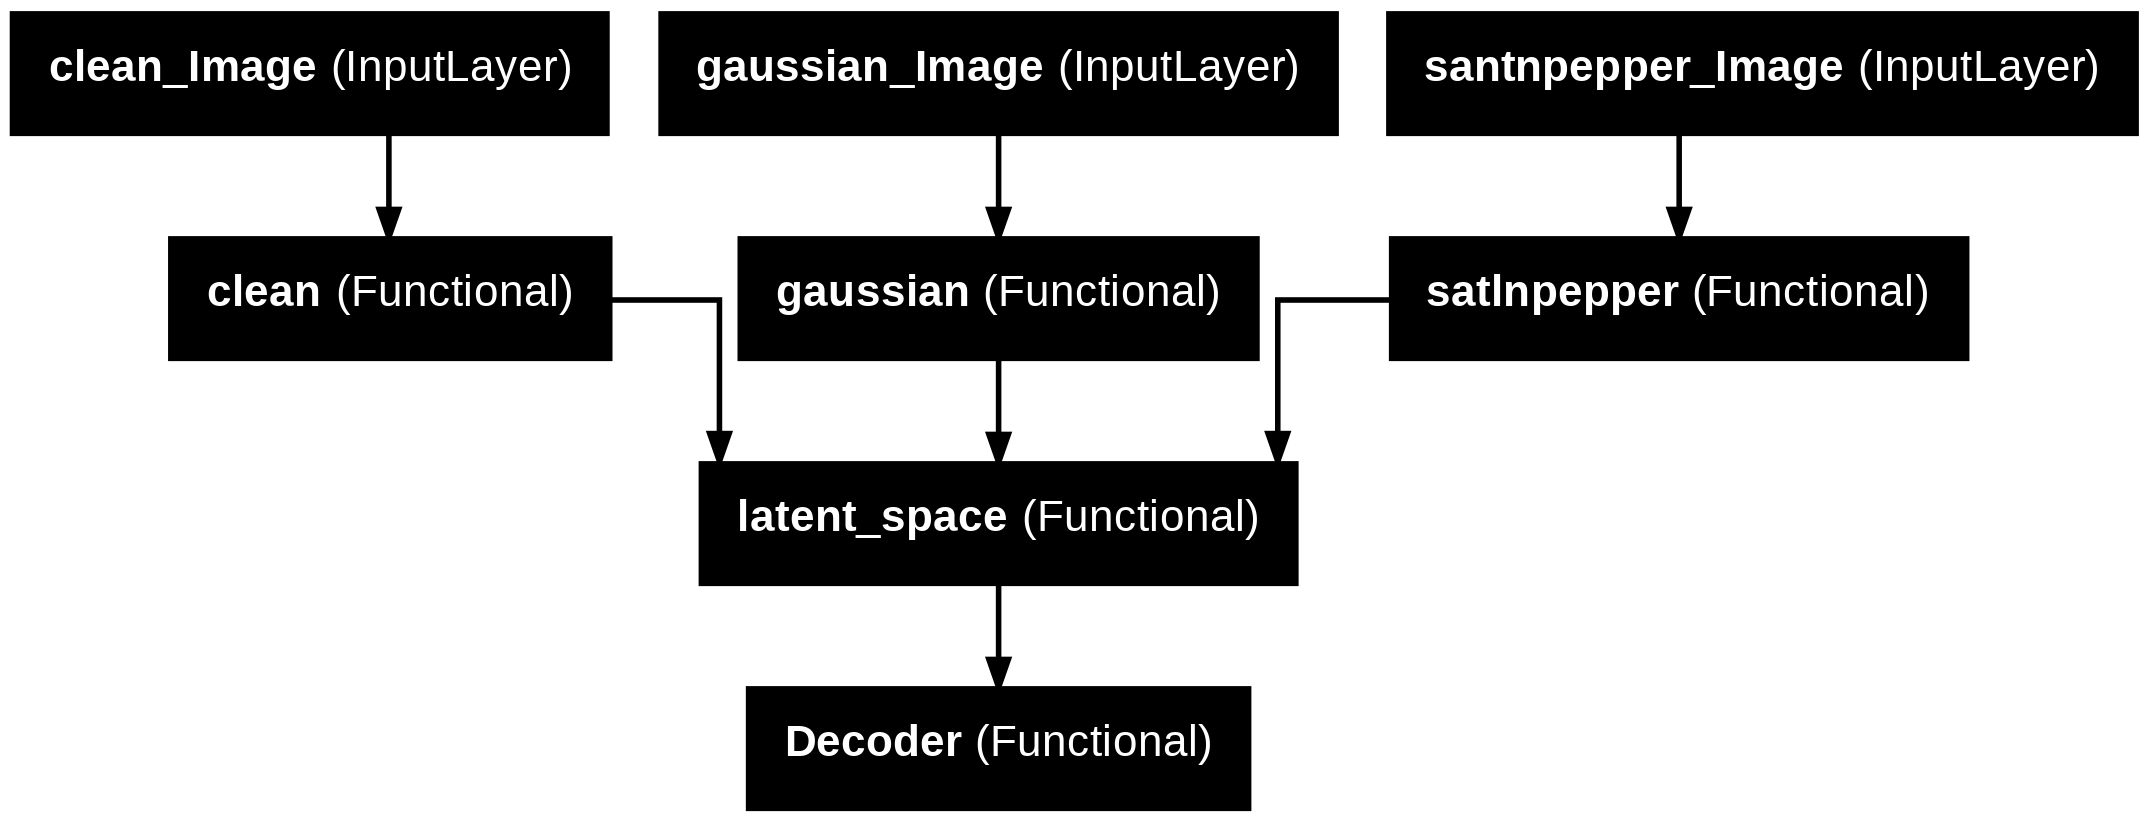

In [88]:
#definimos el tamaño del batch
batch=64
#Definimos la dimension del espacio latente
latent_dim=32
#Creamos los enconders
layer_names =[['cnn1_0','cnn1_1'], ['cnn2_0','cnn2_1'], ['cnn3_0','cnn3_1']]
enc_names = ['clean', 'gaussian', 'satlnpepper']

encoder_clean = build_encoder(layer_names[0][0],layer_names[0][1], enc_names[0])
encoder_gaussian = build_encoder(layer_names[1][0],layer_names[1][1], enc_names[1])
encoder_saltnpepper = build_encoder(layer_names[2][0],layer_names[2][1], enc_names[2])

#Creamos el espacio latente
latent_space = build_latent_space(latent_dim)

#Creamos el decoder
decoder = build_decoder(latent_dim)

#Creamos el modelo completo
autoencoder = build_autoencoder([encoder_clean, encoder_gaussian, encoder_saltnpepper], latent_space, decoder)

tf.keras.utils.plot_model(autoencoder,show_layer_names=True)
#autoencoder.summary()

# Compilamos el modelo

In [89]:
lr0 = 0.1
decay = 1e-4
c = 0.5
# Create power decay function
power_decay_fn = power_decay(lr0, decay, c)

# Apply it to the learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(power_decay_fn)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr0),
    loss=["binary_crossentropy", "sparse_categorical_crossentropy", "sparse_categorical_crossentropy"],
    metrics=["mse","accuracy","accuracy"]
)

In [90]:
history=autoencoder.fit([x_train,x_train_gaussian,x_train_saltpepper], [x_train,y_train,y_train_category], epochs=3, batch_size=batch, validation_data=([x_valid,x_valid_gaussian,x_valid_saltpepper], [x_valid,y_valid,y_valid_category]),callbacks=[lr_scheduler])

Epoch 1/3
860/860 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - Decoder_accuracy: 0.2529 - Decoder_accuracy_1: 0.5797 - Decoder_loss: 1.1829 - Decoder_mse: 0.0844 - loss: 99.1128 - val_Decoder_accuracy: 0.1054 - val_Decoder_accuracy_1: 0.4070 - val_Decoder_loss: 1.1948 - val_Decoder_mse: 0.0977 - val_loss: 65.2607 - learning_rate: 0.1000
Epoch 2/3
860/860 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - Decoder_accuracy: 0.3143 - Decoder_accuracy_1: 0.6110 - Decoder_loss: 2.3800 - Decoder_mse: 0.0674 - loss: 90.9457 - val_Decoder_accuracy: 0.0994 - val_Decoder_accuracy_1: 0.4070 - val_Decoder_loss: 1.1064 - val_Decoder_mse: 0.1167 - val_loss: 112.9787 - learning_rate: 0.0960
Epoch 3/3
860/860 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - Decoder_accuracy: 0.1020 - Decoder_accuracy_1: 0.3757 - Decoder_loss: 1.1827 - Decoder_mse: 0.0927 - loss: 82.7248 - val_Decoder_accuracy: 0.0980 - val_Decoder_accuracy_1: 0.4070 - val_Decoder_loss: 1.1476 - val_Decoder_mse: 0.1139 - val_loss: 58.6926 - learning_rate: 0.0924


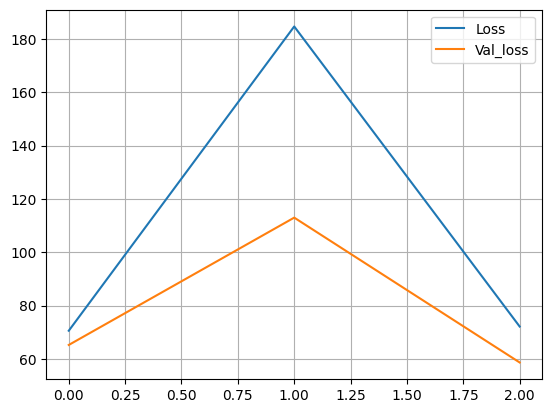

In [91]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()

# Prediccion y visualizacion de resultados

In [92]:
x_pred,y_pred_10,y_pred_3 = autoencoder.predict([x_test,x_test_gaussian,x_test_saltpepper])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [93]:
y_pred_3 = np.argmax(y_pred_3, axis=1)
y_pred_10 = np.argmax(y_pred_10, axis=1)
print(y_pred_3.shape)
print(y_pred_10.shape)

(10000,)
(10000,)


# **Matriz de confusion  y reporte para 3 clases**

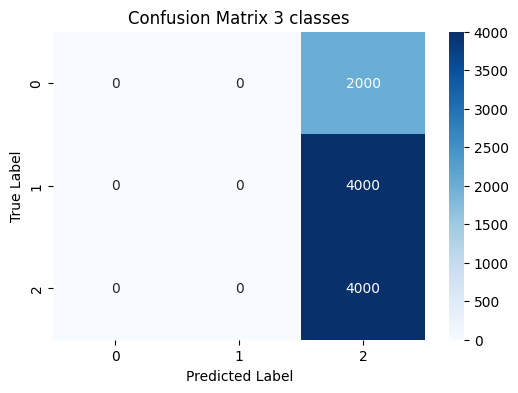

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2000
           1       0.00      0.00      0.00      4000
           2       0.40      1.00      0.57      4000

    accuracy                           0.40     10000
   macro avg       0.13      0.33      0.19     10000
weighted avg       0.16      0.40      0.23     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_category, y_pred_3)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix 3 classes")
plt.show()

report = classification_report(y_test_category, y_pred_3)
print(report)

# **Matriz de confusion y reporte para 10 clases**

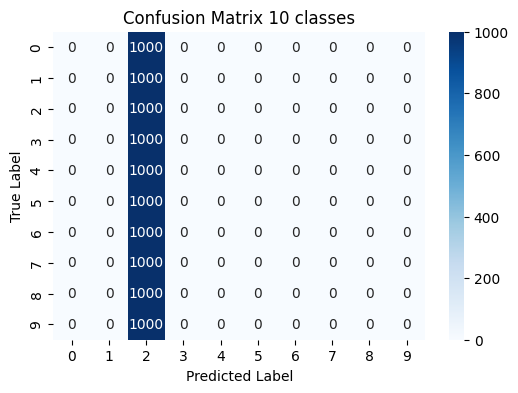

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_10)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix 10 classes")
plt.show()

# Umap del espacio latente

In [96]:
!pip install umap-learn --quiet #librería umap
!pip install datashader bokeh holoviews --quiet #gráficos umap

**Creamos un modelo parcial con la salida del espacio latente**

In [103]:
#Define the partial model
def build_partial(encoders, latent_space):
    # Define three separate inputs for the encoders
    input_img1 = tf.keras.layers.Input(shape=(28, 28, 1), name="clean_Image")
    input_img2 = tf.keras.layers.Input(shape=(28, 28, 1), name="gaussian_Image")
    input_img3 = tf.keras.layers.Input(shape=(28, 28, 1), name="santnpepper_Image")
    
    # Get encoded representations
    encoded1 = encoders[0](input_img1)
    encoded2 = encoders[1](input_img2)
    encoded3 = encoders[2](input_img3)
    
    # Get latent space
    latent_space = latent_space([encoded1,encoded2,encoded3])

    # Define the partial model
    partial = tf.keras.Model([input_img1,input_img2,input_img3], latent_space, name="Partial_Model")

    return partial

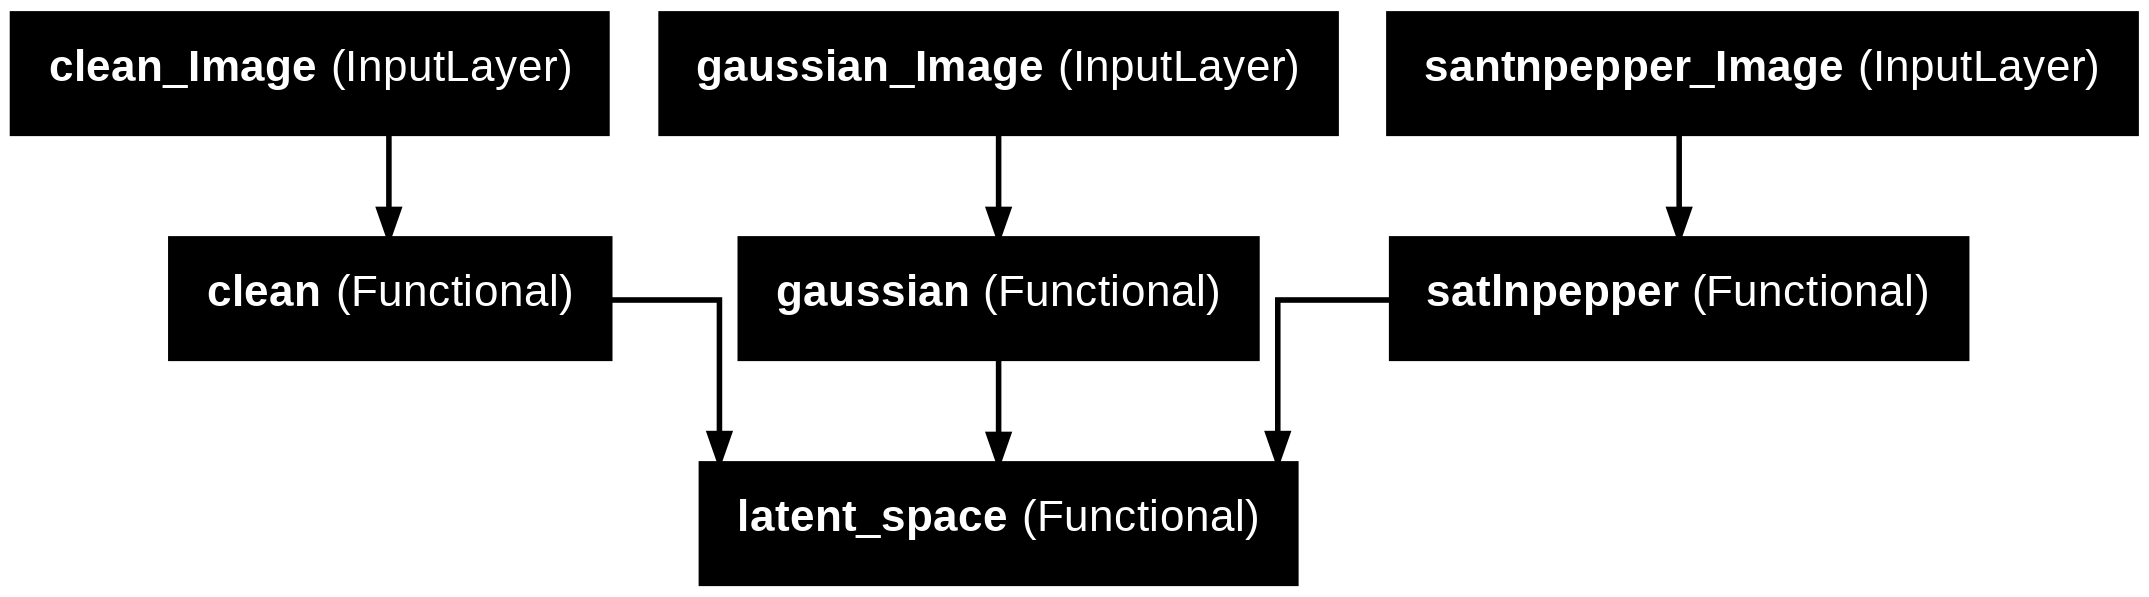

In [104]:
partial_model = build_partial([encoder_clean, encoder_gaussian, encoder_saltnpepper], latent_space)
tf.keras.utils.plot_model(partial_model,show_layer_names=True)

In [105]:
latent_data = partial_model.predict([x_test,x_test_gaussian,x_test_saltpepper])
latent_data.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


(10000, 32)

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)


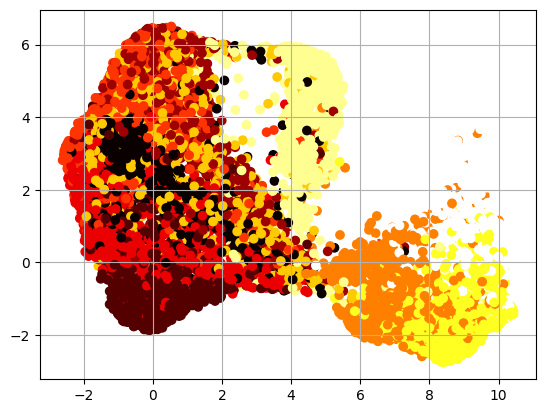

In [106]:
import umap
import umap.plot
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(latent_data)

red = umap.UMAP(n_components=2,n_neighbors=40, min_dist=0.2)
X_reduced_umap = red.fit_transform(data)
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=y_test, cmap=plt.cm.hot)
plt.grid(True)
plt.show()

# CAMs para visualizar si el aporte viene de las entradas ruidosas o de las limpias

In [107]:
#-------------------------------------------------------------------------------
!pip install tf-keras-vis tensorflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.0 MB/s eta 0:00:00


In [108]:
import scipy.io as sio
import pickle
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from sklearn.model_selection import ShuffleSplit
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#--------------------------------------------

# Creamos un modelo parcial con una unica salida de clasificacion 

In [158]:
def build_classificator(encoders, latent_space,decoder):
    # Define three separate inputs for the encoders
    input_img1 = tf.keras.layers.Input(shape=(28, 28, 1), name="clean_Image")
    input_img2 = tf.keras.layers.Input(shape=(28, 28, 1), name="gaussian_Image")
    input_img3 = tf.keras.layers.Input(shape=(28, 28, 1), name="santnpepper_Image")
    
    # Get encoded representations
    encoded1 = encoders[0](input_img1)
    encoded2 = encoders[1](input_img2)
    encoded3 = encoders[2](input_img3)
    
    # Get latent space
    latent_space = latent_space([encoded1,encoded2,encoded3])

    #Get decoder 
    decoded_outputs = decoder(latent_space)
    # Define the full model
    classificator = tf.keras.Model([input_img1,input_img2,input_img3], decoded_outputs, name="10_class_classificator")

    return classificator



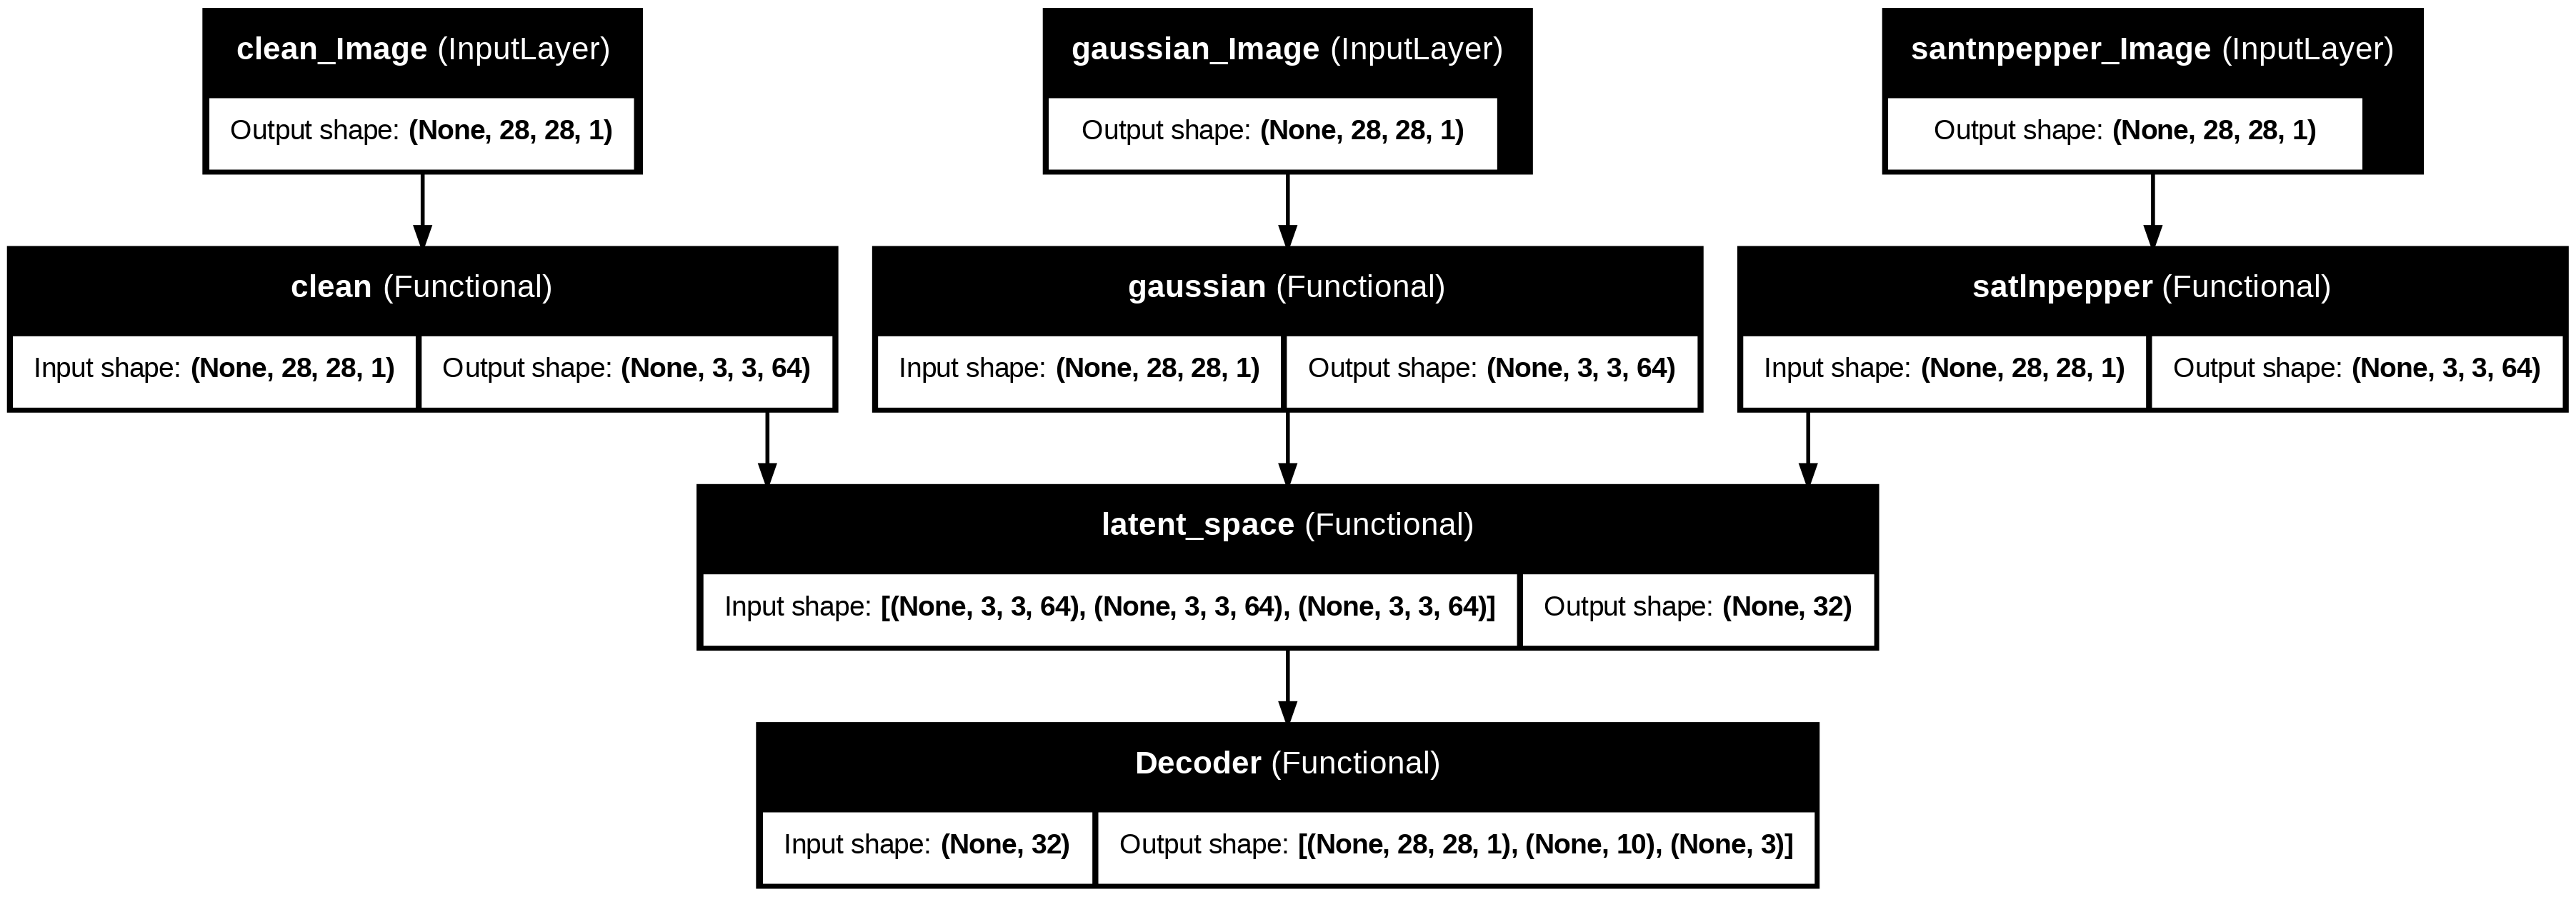

In [159]:
# Create a new model that selects only one classification output
classificator = build_classificator([encoder_clean, encoder_gaussian, encoder_saltnpepper], latent_space, decoder)
tf.keras.utils.plot_model(classificator,show_layer_names=True,show_shapes=True)

In [145]:
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Function to generate GradCAM++ heatmaps
def generate_gradcam_plus_plus_multiple(model, images_list, class_idx, layer_names):
    model_modifier = ReplaceToLinear()  # Modify last layer to linear
    score = CategoricalScore([class_idx])  # Select class index
    gradcam = GradcamPlusPlus(model, model_modifier=model_modifier, clone=True)

    heatmaps_all = []

    # Loop through multiple images
    for sample_inputs in images_list:
        heatmaps = {}
        for layer_name in layer_names:
            heatmap = gradcam(score, sample_inputs, penultimate_layer=layer_name, normalize_cam=True)
            heatmaps[layer_name] = heatmap[0]  # Remove batch dim
        heatmaps_all.append(heatmaps)
    
    return heatmaps_all


# Function to plot GradCAM++ heatmaps
def plot_gradcam_multiple(heatmaps_all, images_list, layer_names):
    num_images = len(images_list)
    
    fig, axes = plt.subplots(num_images, len(layer_names) + 1, figsize=(12, 3 * num_images))

    for img_idx, (heatmaps, sample_inputs) in enumerate(zip(heatmaps_all, images_list)):
        first_input_image = np.squeeze(sample_inputs[0], axis=0)  # Remove batch dim -> (28, 28, 1)

        # Show original image
        axes[img_idx][0].imshow(first_input_image[:, :, 0], cmap='gray')
        axes[img_idx][0].set_title(f"Original {img_idx+1}")
        axes[img_idx][0].axis("off")

        # Show GradCAM++ heatmaps for each layer
        for layer_idx, layer_name in enumerate(layer_names):
            heatmap = heatmaps[layer_name]
            axes[img_idx][layer_idx + 1].imshow(first_input_image[:, :, 0], cmap='gray')
            axes[img_idx][layer_idx + 1].imshow(heatmap[0], cmap='jet', alpha=0.5)  # ✅ Fix: Remove batch dim
            axes[img_idx][layer_idx + 1].set_title(f"GradCAM++ ({layer_name})")
            axes[img_idx][layer_idx + 1].axis("off")

    plt.tight_layout()
    plt.show()



In [146]:
# Select a class index for visualization (e.g., class 0)
class_idx = 0

# Define layers to visualize
layer_names = ["cnn1_0", "cnn2_0", "cnn3_0"]  # You can add more layers

# Select 5 images from x_train and reshape them
num_images = 5
sample_images_list = [
    [np.expand_dims(x_train[i], axis=(0, -1))] * 3  # Shape (1, 28, 28, 1) for each input branch
    for i in range(num_images)
]

# Generate GradCAM++ heatmaps for multiple images
heatmaps_all = generate_gradcam_plus_plus_multiple(classificator, sample_images_list, class_idx, layer_names)

# Plot the results for multiple images
plot_gradcam_multiple(heatmaps_all, sample_images_list, layer_names)

KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m132429610377680\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=['tf.Tensor(shape=(1, 28, 28, 1), dtype=float32)', 'tf.Tensor(shape=(1, 28, 28, 1), dtype=float32)', 'tf.Tensor(shape=(1, 28, 28, 1), dtype=float32)']\n  • training=False\n  • mask=['None', 'None', 'None']"

In [ ]:
##### Select a class index for visualization (e.g., class 0)
class_idx = 0

# Define layers to visualize
layer_names = ["cnn1_1", "cnn2_1", "cnn3_1"]  # You can add more layers

# Select 5 images from x_train and reshape them
num_images = 5
sample_images_list = [
    [np.expand_dims(x_train[i], axis=(0, -1))] * 3  # Shape (1, 28, 28, 1) for each input branch
    for i in range(num_images)
]

# Generate GradCAM++ heatmaps for multiple images
heatmaps_all = generate_gradcam_plus_plus_multiple(model_classification, sample_images_list, class_idx, layer_names)

# Plot the results for multiple images
plot_gradcam_multiple(heatmaps_all, sample_images_list, layer_names)